<font size="6"><b>Scraping Website using HTML Parser Selectolax</b></font>   

<span style='background: blue; font-size: 20px;'>Introduction</span>

We are going to scrape the top 1000 anime on MyAnimeList.
<br>
<br>
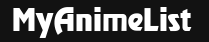

The main page uses limit to page through results. <br>
In the main page, we are scraping Rank, Title, Score and Hyperlink (sub-page) in the middle section <br>

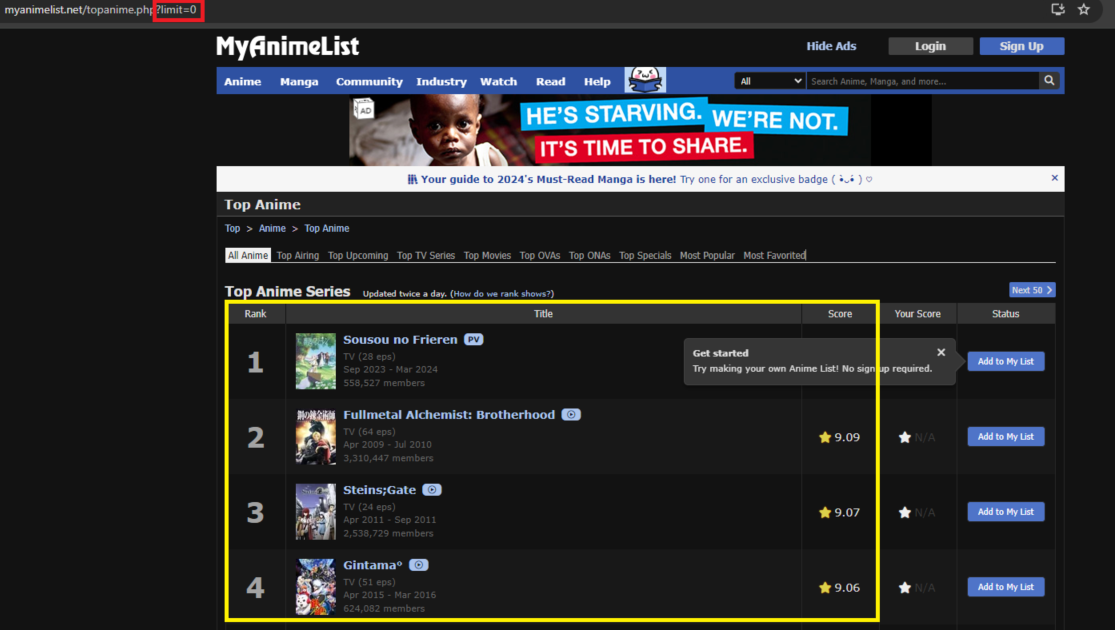

All the infomation we need is under class 'ranking-list'.

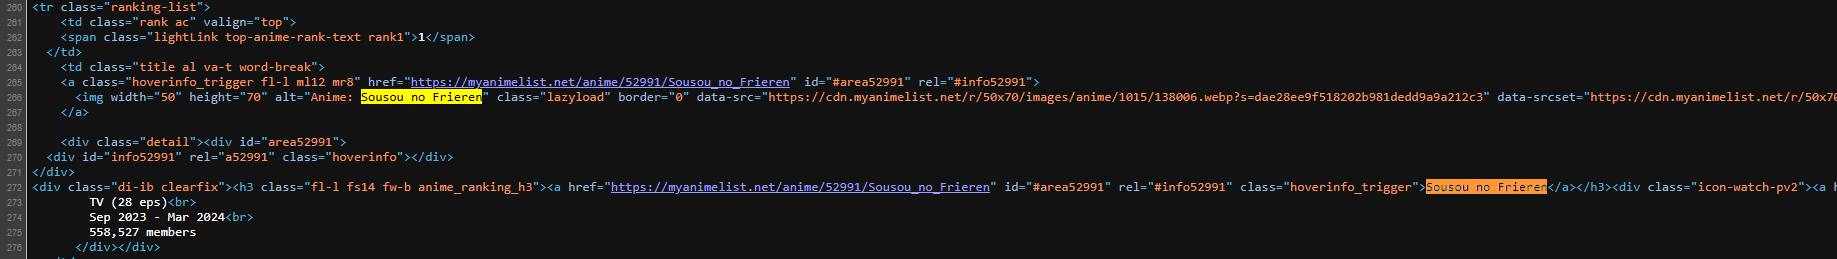

In the sub-page, we are scraping the infomation on the left border and the synopsis in the middle section.

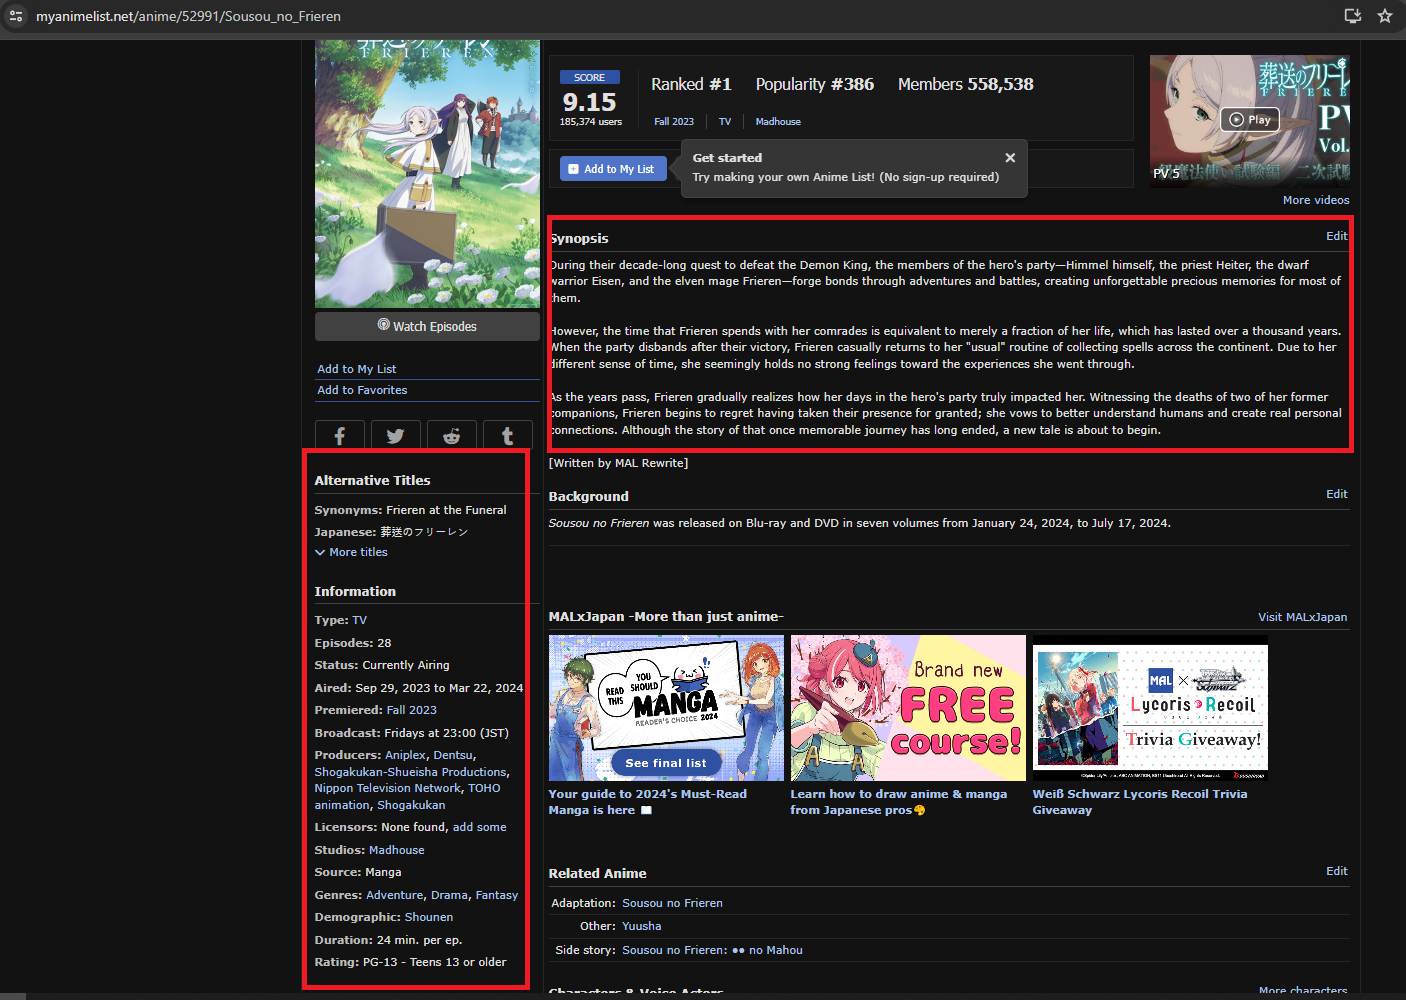

The information on the left border is under class 'spaceit_pad'.

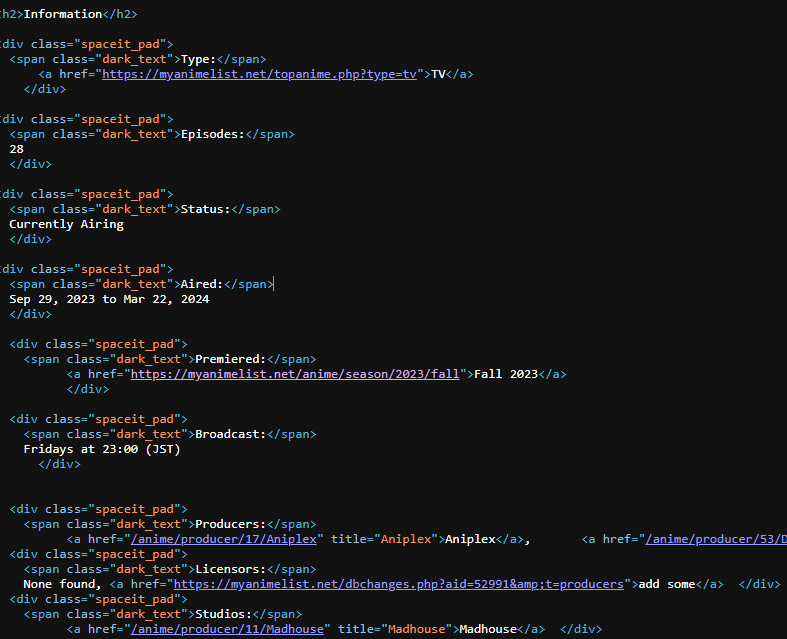

The words before the first ':' will the header, and the words after the first ':' will be the values. 
<br> e.g. Header: Synonyms, 'Frieren at the Funeral'
<br>
<br>The square parts have no ':' in the string, and there is no useful infomation. Therefore, we are not keeping them.

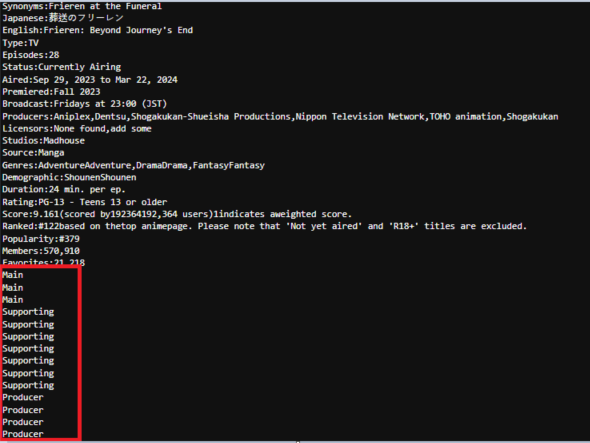

Because the hovering words are also under this class, so we would get duplicated words. We will deduplicate them. 
<br> e.g. 'AdventureAdventure,DramaDrama,FantasyFantasy' to 'Adventure,Drama,Fantasy'

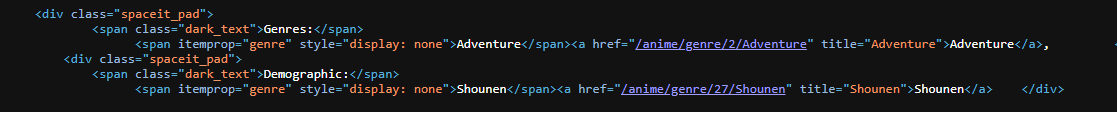
<br>
<br>
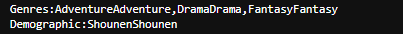

The synopsis is under 'itemprop="description"'.

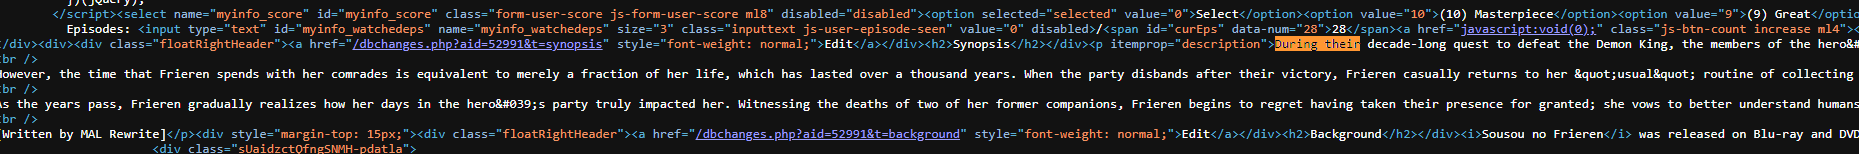

<span style='background: blue; font-size: 20px;'>Codes</span>

Importing the packages

In [1]:
import httpx
from selectolax.parser import HTMLParser
import pandas as pd
import re
import numpy as np

This function is to navigate between the main pages.

In [2]:
def get_html_main_page(page):
    response = httpx.get(f"https://myanimelist.net/topanime.php?limit={page}")
    return HTMLParser(response.text)

This fucntion is to request the server and scrape through the hyperlink in the main page.

In [3]:
def get_html_sub_page(url):
    response = httpx.get(url)
    return HTMLParser(response.text)

Scraping infomation in the main-page and sub-page.

In [4]:
def scrape(html):
    
    anime_list = []
    
    #Scraping the main-page
    
    for item in html.css('.ranking-list'):
        result = {}
        result['Title'] = item.css_first('.title').text(strip=True)
        result['Score_Main'] = item.css_first('.score').text(strip=True)
        result['Rank'] = item.css_first('.rank').text(strip=True)
        Link = item.css_first('.title a').attributes['href']
        result['Link'] = Link
        
    #Scraping the sub-page
    
        sub_page = get_html_sub_page(Link)
    
        for item in range(len(sub_page.css('.spaceit_pad'))):
            if len(sub_page.css('.spaceit_pad')[item].text(strip=True).split(':', 1)) >= 2:
                result[sub_page.css('.spaceit_pad')[item].text(strip=True).split(':',1)[0]] = sub_page.css('.spaceit_pad')[item].text(strip=True).split(':',1)[1]
        
    #Scraping the synopsis in the middle part
    
        result['Description'] = sub_page.css_first('p[itemprop="description"]').text()
        anime_list.append(result)
        
    return anime_list

Deduplicating Demographic, Theme, Genre

In [5]:
def deduplicate(string):
    result = []
    
    if pd.notna(string):
        for word in string.split(','):
            tmp = ''
            for character in word:
                tmp += character
                if word == ''.join(re.findall(re.escape(tmp),word)):
                    result.append(tmp)
                    break
        return ','.join(result)
    return np.NaN

converting a list of dictionary to a pandas dataframe

In [6]:
def dict_to_df(list_of_dict):
    df = pd.DataFrame(list_of_dict)
    return df

In [7]:
def main():
    df = pd.DataFrame()
    for x in range(0,1000,50):
        html = get_html_main_page(x)
        final_result = scrape(html)
        df_tmp = dict_to_df(final_result)
        df = pd.concat([df, df_tmp], ignore_index=True, sort=False)
                       
    #data cleaning
    #combining columns 'Demographic & Demographics', 'Theme & Themes' and 'Genre & Genres'
    df['Demographic'] = df['Demographic'].combine_first(df['Demographics'])
    df['Theme'] = df['Theme'].combine_first(df['Themes'])
    df['Genre'] = df['Genre'].combine_first(df['Genres'])

    df.drop(['Demographics', 'Themes', 'Genres'], axis=1, inplace = True)
                   
    
    df['Demographic'] = df['Demographic'].apply(deduplicate)
    df['Theme'] = df['Theme'].apply(deduplicate)
    df['Genre'] = df['Genre'].apply(deduplicate)
    
    #exporting result to a utf-8 csv file
    df.to_csv(r'D:\Susanna\Portfolio\Scrap_anime\anime.csv', encoding='utf-8-sig', index = False)

In [8]:
if __name__ == '__main__':
    main()

In [9]:
df = pd.read_csv(r'D:\Susanna\Portfolio\Scrap_anime\anime.csv')

df.head()

,Title,Score_Main,Rank,Link,Synonyms,Japanese,English,Type,Episodes,Status,...,Ranked,Popularity,Members,Favorites,Description,French,Theme,German,Spanish,Genre
0,Sousou no FrierenTV (28 eps)Sep 2023 - Mar 202...,9.16,1,https://myanimelist.net/anime/52991/Sousou_no_...,Frieren at the Funeral,葬送のフリーレン,Frieren: Beyond Journey's End,TV,28,Currently Airing,...,#122based on thetop animepage. Please note tha...,#379,"571,328","21,282",During their decade-long quest to defeat the D...,NaN,NaN,NaN,NaN,"Adventure,Drama,Fantasy"
1,Fullmetal Alchemist: BrotherhoodTV (64 eps)Apr...,9.09,2,https://myanimelist.net/anime/5114/Fullmetal_A...,"Hagane no Renkinjutsushi: Fullmetal Alchemist,...",鋼の錬金術師 FULLMETAL ALCHEMIST,Fullmetal Alchemist: Brotherhood,TV,64,Finished Airing,...,#222based on thetop animepage. Please note tha...,#3,"3,313,754","224,377",After a horrific alchemy experiment goes wrong...,Fullmetal Alchemist Brotherhood,Military,NaN,NaN,"Action,Adventure,Drama,Fantasy"
2,"Steins;GateTV (24 eps)Apr 2011 - Sep 20112,541...",9.07,3,https://myanimelist.net/anime/9253/Steins_Gate,NaN,STEINS;GATE,Steins;Gate,TV,24,Finished Airing,...,#322based on thetop animepage. Please note tha...,#13,"2,541,066","188,453",Eccentric scientist Rintarou Okabe has a never...,NaN,"Psychological,Time Travel",NaN,NaN,"Drama,Sci-Fi,Suspense"
3,"Gintama°TV (51 eps)Apr 2015 - Mar 2016624,689 ...",9.06,4,https://myanimelist.net/anime/28977/Gintama°,Gintama' (2015),銀魂°,Gintama Season 4,TV,51,Finished Airing,...,#422based on thetop animepage. Please note tha...,#338,"624,680","16,539","Gintoki, Shinpachi, and Kagura return as the f...",Gintama Saison 4,"Gag Humor,Historical,Parody,Samurai",Gintama Season 4,Gintama Temporada 4,"Action,Comedy,Sci-Fi"
4,Shingeki no Kyojin Season 3 Part 2TV (10 eps)A...,9.05,5,https://myanimelist.net/anime/38524/Shingeki_n...,NaN,進撃の巨人 Season3 Part.2,Attack on Titan Season 3 Part 2,TV,10,Finished Airing,...,#522based on thetop animepage. Please note tha...,#21,"2,247,476","58,167",Seeking to restore humanity's diminishing hope...,L'Attaque des Titans Saison 3 Partie 2,"Gore,Military,Survival",Attack on Titan Staffel 3 Teil 2,Ataque a los Titanes Temporada 3 Parte 2,"Action,Drama,Suspense"
